# Forecasting the Number of Allergy Shots Given Per Day
- the data for this project is the number of daily shots that are given in a clinic for a client of mine
- my objective is to create a model that can predict the number of shots that this clinic gives daily
- the business use case for this project is to help the CEO of the company understand how many nurses to schedule per day as a function of the number of injections
- nurses are currently arbitrarily assigned (in terms of the number of nurses on duty), which leads to either over or under-staffing issues
- if this model succeeds, then the company can staff the clinic accordingly, thus saving money and improving patient care

In [79]:
import os
import numpy.random as nr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_profiling
import seaborn as sns
import missingno as msno
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 5000)
from datetime import datetime
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import plotly_express as px

#lines below let allow multiple results from a line of code to be shown e.g. df.head() + df.columns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#displaying numbers instead of scientific notation
pd.options.display.float_format = '{:.2f}'.format

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

#modeling
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn_pandas import DataFrameMapper
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing

# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults, AR
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

#stationarity assumption
from statsmodels.tsa.stattools import adfuller

#normal assumption
from scipy import stats

#trend analysis
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose

#deep learning for time series modeling
# import keras
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM
# from keras.preprocessing.sequence import TimeseriesGenerator

#prophet forecasting
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

In [80]:
pwd

'C:\\Users\\Sam Cannon\\Desktop\\MAAC\\Forecasting'

In [81]:
#import the data, I used SQL to aggregate the data beforehand and simply exported it as a csv file, so some of the data cleaning was in SQL
df = pd.read_csv('daily_injections.csv', header = None, names = ['date', 'day', 'number_of_injections', 'location'])

In [82]:
#take a look at the head of the data
df.head()

,date,day,number_of_injections,location
0,2019-12-31,31,221,Jackson
1,2019-12-30,30,297,Jackson
2,2019-12-27,27,202,Jackson
3,2019-12-26,26,145,Jackson
4,2019-12-23,23,255,Jackson


In [83]:
#order the df for date ascending rather than descending
df.sort_values('date', inplace = True)

In [84]:
df.head(1)

,date,day,number_of_injections,location
1008,2016-01-04,4,217,Jackson


In [85]:
#set the index to the timestamp
df.set_index('date', inplace = True)

In [86]:
#set the frequency of the index to daily
df.index.freq = 'd'

In [87]:
#make df only the observations
df = df[['number_of_injections']]

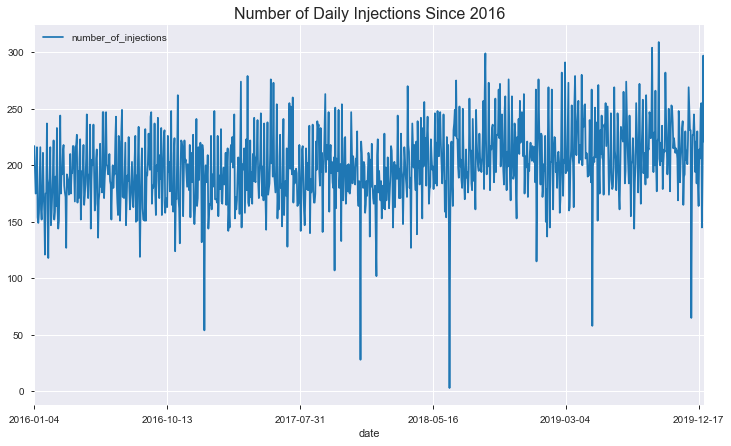

In [27]:
df.plot(figsize = (12, 7))
plt.title('Number of Daily Injections Since 2016', fontsize = 16);

__Rolling Means__
- Now I want to look at plotting the data vs a "rolling mean", which is just the average of whatever window size that you specify
- I am going to play around with several different window sizes to find a good fit for the data
- rolling means can be used to forecast by themselves, or can be used as window features in rolling window regression models
    - I want to use the rolling mean for a rolling window regression later on in this project, so that is why it is here

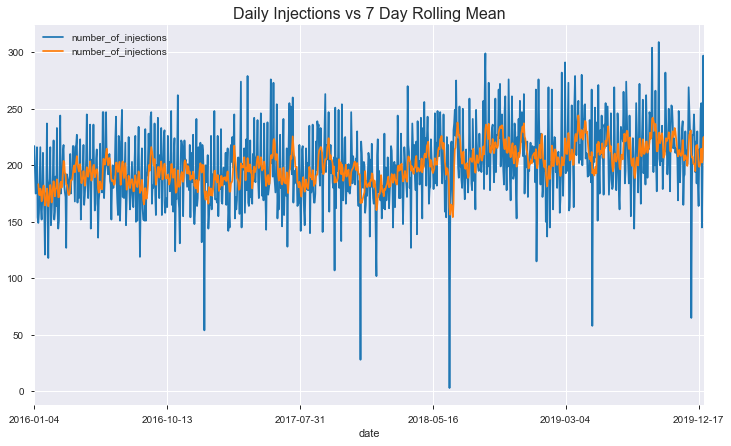

In [28]:
#now plot data against a rolling mean with a window size of 
df.plot(legend = True, figsize = (12, 7))
plt.title('Daily Injections vs 7 Day Rolling Mean', fontsize = 16)

#we can make the window ANY size
df.rolling(window = 7).mean()['number_of_injections'].plot(legend = True);

__Finding Overall Trends__
- I am going to use the hodrick-prescott filter to find the overall trend for this beat's call volume
- you can set the filter for windows of data, I am going to use quarterly (by setting lambda value)
- trends are useful to know so that you can choose the correct models, i.e. SARIMA or ARIMA, etc.

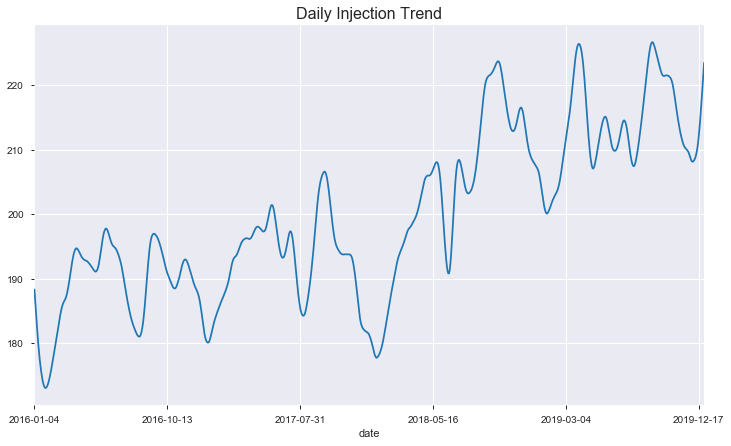

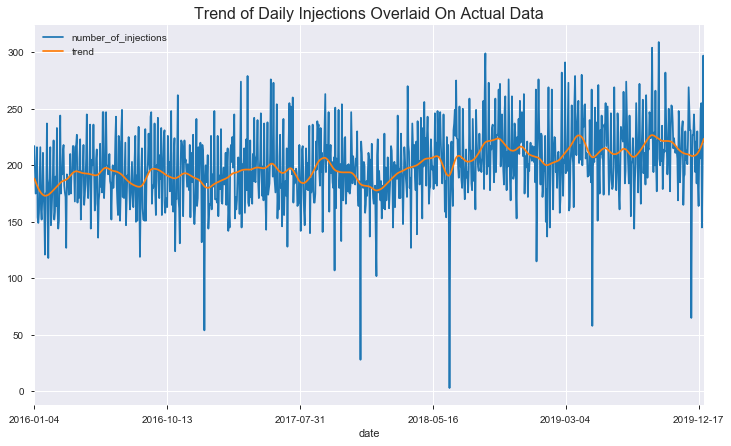

In [29]:
#use statsmodels to get the trend (hodrick-prescott filter)
# tuple unpacking gdp_cycle, gdp_trend
cycle, trend = hpfilter(df.number_of_injections, lamb = 1600)

trend.plot(figsize = (12, 7))
plt.title('Daily Injection Trend', fontsize = 16)

#add trend column to d1_2019 so that we can plot the trend on top of the df
df['trend'] = trend

#plot the trend over the data
df[['number_of_injections', 'trend']].plot(figsize = (12, 7))
plt.title('Trend of Daily Injections Overlaid On Actual Data', fontsize = 16);

__ETS Decomposition (Error, Trend, Seasonality)__
- decomposing the data into these subplots shows that there is clearly trend and seasonality to the data

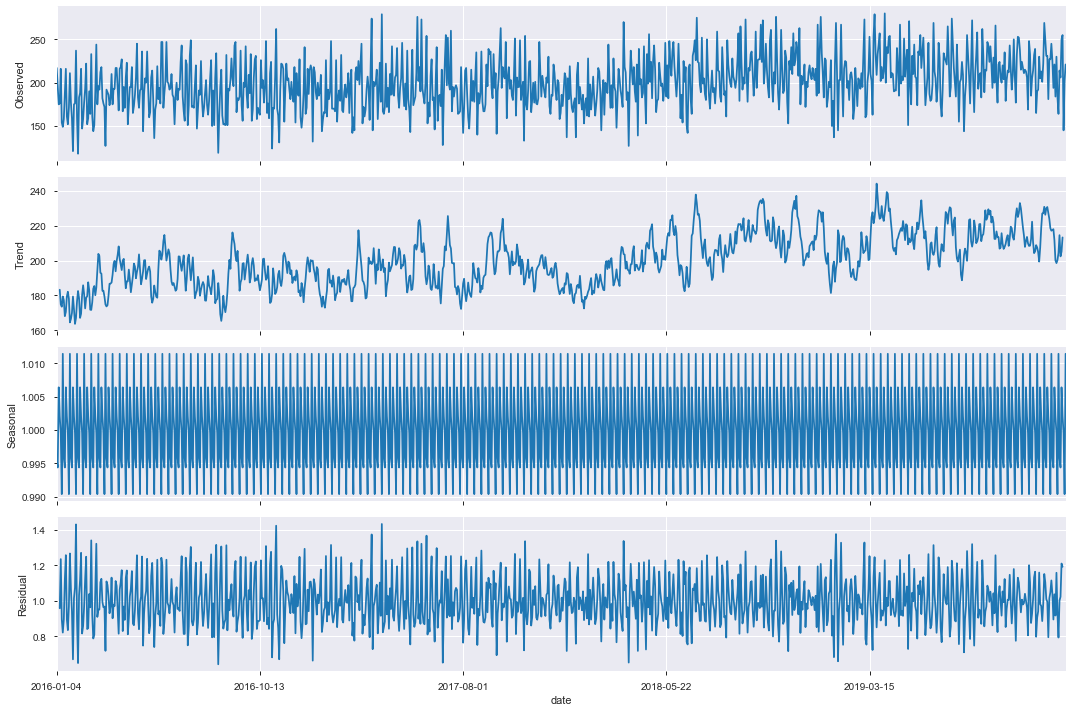

In [41]:
#this is basically separating our data into three different facets, error/seasonality/trend, so we can call those three things as if they are methods of the 
# multiplicative model
results = seasonal_decompose(df['number_of_injections'], model = 'mult', freq = 7)

#make plot larger
from pylab import rcParams

rcParams['figure.figsize'] = 15, 10 #specify figsize

results.plot(); #we have to put the ; after the plot for some reason, its weird without it

__Is this data stationary?__
- I am going to use the augmented dickey-fuller test to determine if the data is in need of differencing to create stationarity
- stationary data is needed for quality predictions in time series modeling

__While there is a trend and seasonality, this data still passes then augmented dickey-fuller test, which is wierd to me__

In [31]:
#testing stationarity, whether there is a trend or seasonality, it says no but the plot suggests otherwise???
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

adf_test(df['number_of_injections'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -3.17
p-value                  0.02
# lags used             22.00
# observations         986.00
critical value (1%)     -3.44
critical value (5%)     -2.86
critical value (10%)    -2.57
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


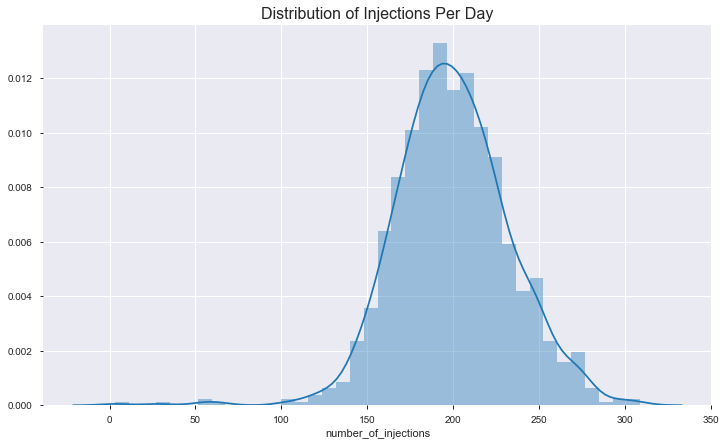

In [88]:
#check to see if the distribution of the residuals is normal, this would be ideal for modeling, it seems as though the data is close to normally distributed
plt.figure(figsize = (12, 7))
sns.distplot(df['number_of_injections'])
plt.title('Distribution of Injections Per Day', fontsize = 16);

In [33]:
#checking skew and kurtosis, looks like the data is skewed, which will probably throw off a normality test
df['number_of_injections'].skew()
df['number_of_injections'].kurtosis()

-0.2941537349271017

2.340160924881029

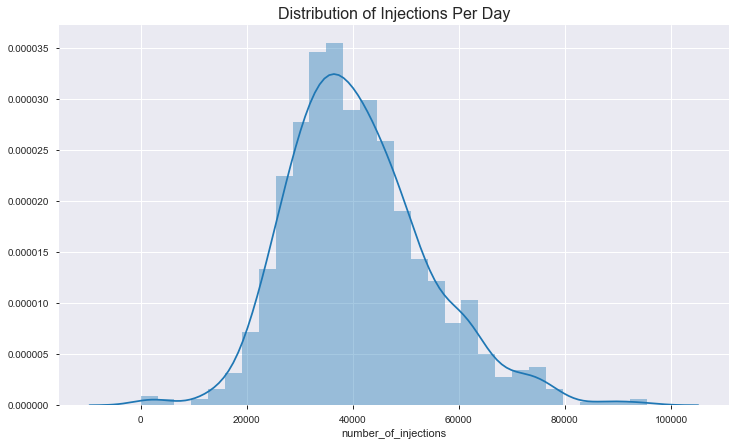

In [96]:
#what if I transform the data a bit? Not that much different, seems to have a small additional mode at the end as well
sns.distplot(df['number_of_injections']**2)
plt.title('Distribution of Injections Per Day', fontsize = 16);

In [92]:
#we can also run a shapiro-wilk test for normality testing, this shows us that we are dealing with non-normal data, but I am not overly concerned with this right
# now since the data is not too different from normal in the visual, I will keep this in mind moving forward though and potentially try to transform the data
stats.normaltest(df['number_of_injections'])

NormaltestResult(statistic=200.55387909975843, pvalue=2.820190798937093e-44)

# Forecasting with the Holt-Winters Method
- I am going to use exponential smoothing to forecast daily injections
- Exponential smoothing is a time series forecasting method for univariate data.
    - Time series methods like the Box-Jenkins ARIMA family of methods develop a model where the prediction is a weighted linear sum of recent past observations or    lags.

    - Exponential smoothing forecasting methods are similar in that a prediction is a weighted sum of past observations, but the model explicitly uses an exponentially decreasing weight for past observations, this means that more recent observations recieve higher weights.
- I have used a "multiplicative" model for exponential smoothing, which deals with the trend in the data, while this can be tricky to diagnose (wether the data is additive or multiplicative) I simply tried the models both ways and used the best outcome, which was multiplicative
- __I also want to note that I tried ARIMA based models as well as SARIMA for forecasting and exponential smoothing beat these models, which is why they have not been included__

## Double Exponential Smoothing

In [54]:
#explicitly make training data a 'double' type, which is the only type of data that exponential smoothing seems to take
df = df.astype('double')

df['DESmul12'] = ExponentialSmoothing(df['number_of_injections'], trend = 'mul', seasonal_periods = 1008).fit().fittedvalues.shift(-1)
df.head()

,number_of_injections,trend,DESmul12,TESmul12
date,,,,
2016-01-04,217.00,188.31,215.01,216.31
2016-01-05,196.00,186.74,211.77,194.79
2016-01-06,175.00,185.20,206.29,173.43
2016-01-07,176.00,183.69,201.21,173.95
2016-01-08,216.00,182.24,201.04,212.96


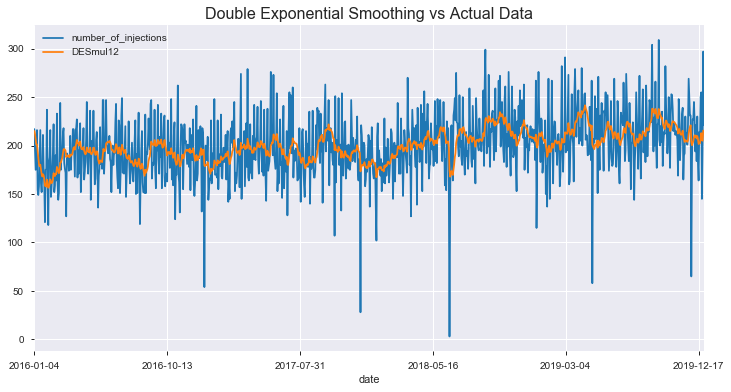

In [55]:
df[['number_of_injections','DESmul12']].plot(figsize=(12,6)).autoscale(axis='x',tight=True)
plt.title('Double Exponential Smoothing vs Actual Data', fontsize = 16);

___
## Triple Exponential Smoothing
Triple Exponential Smoothing, the method most closely associated with Holt-Winters, adds support for both trends and seasonality in the data. 



In [56]:
df.shape

(1009, 4)

In [57]:
#playing around with seasonal_periods will fit the data eventually
df['TESmul12'] = ExponentialSmoothing(df['number_of_injections'],trend='mul',seasonal='mul',seasonal_periods=1008).fit().fittedvalues
df.head()

,number_of_injections,trend,DESmul12,TESmul12
date,,,,
2016-01-04,217.00,188.31,215.01,217.41
2016-01-05,196.00,186.74,211.77,195.30
2016-01-06,175.00,185.20,206.29,175.31
2016-01-07,176.00,183.69,201.21,176.00
2016-01-08,216.00,182.24,201.04,216.00


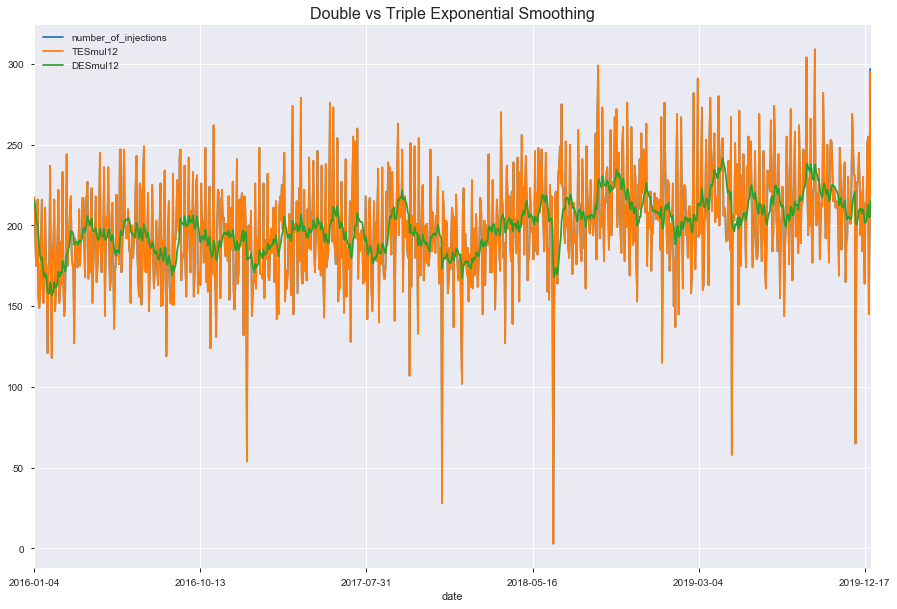

In [58]:
#clearly triple exponential smoothing worked better
df.number_of_injections.plot(legend = True)
df.TESmul12.plot(legend = True)
df.DESmul12.plot(legend = True)
plt.title('Double vs Triple Exponential Smoothing', fontsize = 16);

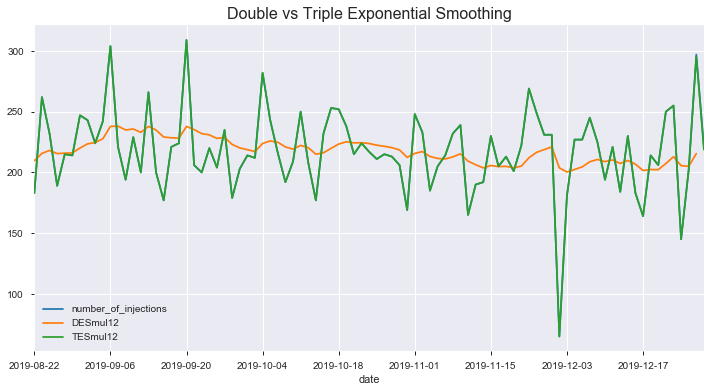

In [59]:
#triple exponential smoothing is essentially perfectly overlaid with the data
df[['number_of_injections','DESmul12','TESmul12']].iloc[920:].plot(figsize=(12,6)).autoscale(axis='x',tight=True)
plt.title('Double vs Triple Exponential Smoothing', fontsize = 16);

__Evaluate The Model__

In [138]:
df.shape

(1009, 1)

In [139]:
# I want to forecast one business week in advance, which means 5 days, I have to transform the data into a 'double' dtype as well for Exponential Smoothing
train = df['number_of_injections'][:1004].astype('double')
test = df['number_of_injections'][1004:].astype('double')

__Fitting the model with several different seasonality values, finding which one produces the lowest RMSE for a week of predictions__

In [140]:
#brute force search for lowest RMSE by iterating through every possible seasonal_period in the data
seasonality_list = list(range(2, 1009, 1))
errors = []
for days in seasonality_list:
    try:
        errors.append(np.sqrt(mean_squared_error(test, ExponentialSmoothing(train, trend = 'mul', seasonal = 'mul', seasonal_periods = days).fit().forecast(5))))
    except: #some of the seasonal_periods produce nan values due to the inability for the model to account for that periodicity, so I have to bypass those 
        errors.append(0) #append 0 to the list of errors if an exception occurs

In [141]:
#looking for lowest RMSE for seasonal_periods
for idx, x in enumerate(errors):
    if x < 30 and x != 0:
        print(idx, x)

378 29.524576453173037
779 27.560115179246992


In [142]:
# looks like 781 is the best number here (index + 2)
fitted_model = ExponentialSmoothing(train, trend='mul',seasonal='mul',seasonal_periods=781).fit()

In [143]:
#forecast
test_predictions = fitted_model.forecast(5).rename('HW Forecast')

#set the index of the test predictions to datetime of test set
test_predictions = pd.DataFrame(test_predictions).set_index(test.index)

In [144]:
test

date
2019-12-23   255.00
2019-12-26   145.00
2019-12-27   202.00
2019-12-30   297.00
2019-12-31   221.00
Name: number_of_injections, dtype: float64

In [145]:
test_predictions

,HW Forecast
date,
2019-12-23,238.01
2019-12-26,170.70
2019-12-27,211.49
2019-12-30,244.54
2019-12-31,223.60


In [146]:
#evaluate Model
print(f'RMSE of Triple Exponential Smoothing: {np.sqrt(mean_squared_error(test,test_predictions))} Injections Per Day')

RMSE of Triple Exponential Smoothing: 27.560115179246992 Injections Per Day


## Predict Future Data 

In [147]:
# Make predictions
fcast = fitted_model.predict(start=len(df), end=len(df)+4).rename('Forecast')

In [148]:
fcast

1009   225.79
1010   211.48
1011   199.37
1012   221.36
1013   204.86
Name: Forecast, dtype: float64

## Searching for Outliers
- outliers can skew our data and negatively impact the model
- I am going to search for outliers within + or - 3 standard deviations from the mean through z-scoring the data
    - z-scoring subtracts the mean and divides by the standard deviation, scaling every value, then we can use these to mark outliers
- I am also going to look for outliers using the Interquartile Range (IQR)
    - values falling outside of 1.5 times the IQR are considered to be outliers
- combining these two methods will help to ensure that I am capturing all outliers in the data

In [159]:
#function created so that I can re-use it if I need to look for outliers with different standard deviation thresholds
def z_score_outliers(x, threshold):
    
    '''returns index of outliers and their values as zip object
    arguments: column of dataframe as x, threshold of standard deviations (typically 3) as z-score threshold
    '''
    import numpy as np
    from scipy import stats
    z = np.abs(stats.zscore(x))
    outliers = x[z > threshold]
    outliers_index = x[z > threshold].index
    outlier_pairs = zip(outliers_index, outliers)
    return [outlier for outlier in outlier_pairs]

In [160]:
#find and inspect outliers with z-score
outliers = z_score_outliers(df['number_of_injections'], 3)
outliers

[('2017-01-06', 54),
 ('2017-12-08', 28),
 ('2018-06-21', 3),
 ('2019-04-29', 58),
 ('2019-09-06', 304),
 ('2019-09-20', 309),
 ('2019-12-02', 65)]

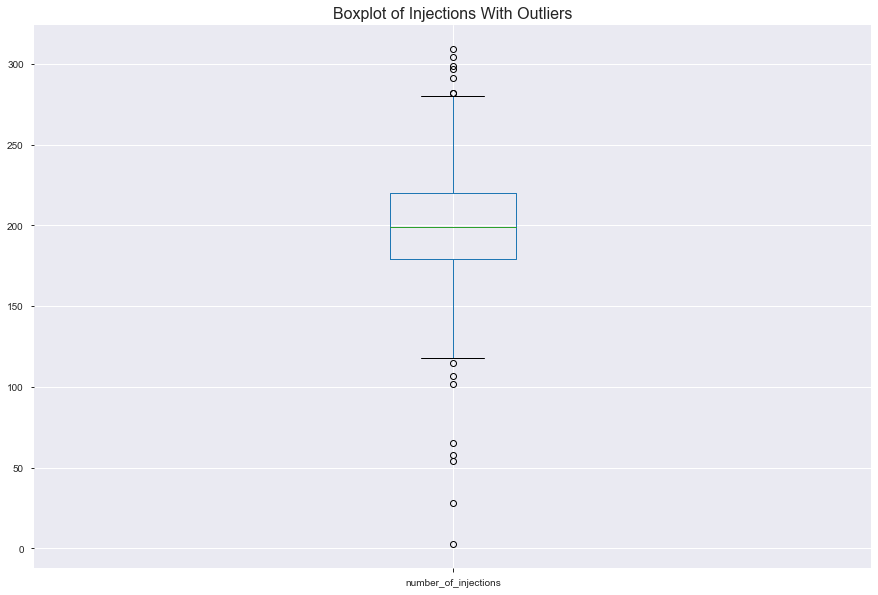

In [136]:
#searching for outliers using boxplot
df['number_of_injections'].plot(kind = 'box')
plt.title('Boxplot of Injections With Outliers', fontsize = 16);

In [18]:
#using the lower and upper quantiles to find outliers
q1 = pd.DataFrame(df).quantile(0.25)[0]
q3 = pd.DataFrame(df).quantile(0.75)[0]
iqr = q3 - q1 #Interquartile range

fence_low = q1 - (1.5*iqr)
fence_high = q3 + (1.5*iqr)

print(f'Lower Quantile Outliers are Below: {fence_low} Injections Per Day')
print(f'Upper Quantile Outliers are Above: {fence_high} Injections Per Day')

Lower Quantile Outliers are Below: 117.5 Injections Per Day
Upper Quantile Outliers are Above: 281.5 Injections Per Day


In [70]:
#I am going to remove all outliers included outside of lower and upper fences
outliers = []
outliers.append(df[df['number_of_injections'] > 281.5]['number_of_injections'])
outliers.append(df[df['number_of_injections'] < 117.5]['number_of_injections'])
outliers = pd.concat(outliers)
outliers = [outlier for outlier in outliers]

In [71]:
#drop outliers from data
for x in df['number_of_injections']:
    if x in outliers:
        df = df[df['number_of_injections'] != x]

## Model Without Outliers

In [72]:
#We have indeed dropped all of the outliers
df.shape

(994, 3)

In [73]:
#create new training and test sets since dropping outliers
train_without_outliers = df['number_of_injections'][:989].astype('double')
test_without_outliers = df['number_of_injections'][989:].astype('double')

In [115]:
#brute force search for lowest RMSE by iterating through every possible seasonal_period in the data without outliers
seasonality_list = list(range(2, 994, 1))
errors = []
for days in seasonality_list:
    try:
        errors.append(np.sqrt(mean_squared_error(test_without_outliers, ExponentialSmoothing(train_without_outliers, trend = 'mul', seasonal = 'mul', seasonal_periods = days).fit().forecast(5))))
    except: #some of the seasonal_periods produce nan values due to the inability for the model to account for that periodicity, so I have to bypass those 
        errors.append(0) #append 0 to the list of errors if an exception occurs

__Looking at this new list of RMSEs, it is clear that removing the outliers has improved the model's error rate significantly__

In [118]:
#brute force search for RMSE without outliers, looks like there are significantly better predictive patterns after removing the outliers from the data
for idx, x in enumerate(errors):
    if x < 20 and x != 0:
        print(idx, x)

522 17.167369141101197
575 17.69097856616002
614 19.598173863203368
777 16.798608286053906
860 18.687448244578626
904 18.456433513327127
919 16.434027459412125


In [119]:
#looks like 921 (index of 919 + 2 for actual day value) is the best number here for the lowers RMSE
fitted_model = ExponentialSmoothing(train_without_outliers, trend='mul',seasonal='mul',seasonal_periods=921).fit()

In [120]:
#forecast
test_without_outliers_predictions = fitted_model.forecast(5).rename('HW Forecast')

In [121]:
#look at the test data
test_without_outliers

date
2019-12-20   250.00
2019-12-23   255.00
2019-12-26   145.00
2019-12-27   202.00
2019-12-31   221.00
Name: number_of_injections, dtype: float64

In [122]:
#look at the predictions
test_without_outliers_predictions

989   225.59
990   244.09
991   167.14
992   192.18
993   214.01
Name: HW Forecast, dtype: float64

In [124]:
#evaluate new Model
print(f'RMSE of Triple Exponential Smoothing After Outlier Removal: {np.sqrt(mean_squared_error(test_without_outliers,test_without_outliers_predictions))} Injections Per Day')

RMSE of Triple Exponential Smoothing After Outlier Removal: 16.434027459412125 Injections Per Day


## Predicting Future Data With New Model

In [125]:
# Make predictions
fcast_without_outliers = fitted_model.predict(start=len(df), end=len(df)+5).rename('Forecast')

In [126]:
fcast_without_outliers

994   214.08
995   239.22
996   181.51
997   190.33
998   204.60
999   226.53
Name: Forecast, dtype: float64

## Nischal, I looked into the data further after our call and was able to pull data about injections since 2012, which added more than 700 data points!

# Full Data Set EDA and Exponential Smoothing
- The above data set was used with only data since 2016, I was able to pull data since 2012 from the SQL server after talking with my stakeholer, who was mistaken in believing that the injections were only a program since 2016, glad I dug into the data more in SQL!

In [106]:
#import the data, I used SQL to aggregate the data beforehand and simply exported it as a csv file, so some of the data cleaning was in SQL
new_df = pd.read_csv('daily_injections_since_2010.csv', header = None, names = ['date', 'number_of_injections', 'location'])

In [107]:
#take a look at the head of the data
new_df.head()

,date,number_of_injections,location
0,2010-09-04,3,Jackson
1,2012-01-07,1,Jackson
2,2012-01-25,1,Jackson
3,2012-01-29,1,Jackson
4,2012-02-11,1,Jackson


In [108]:
#order the df for date ascending rather than descending
new_df.sort_values('date', inplace = True)

In [109]:
new_df.head(1)

,date,number_of_injections,location
0,2010-09-04,3,Jackson


In [110]:
#set the index to the timestamp
new_df.set_index('date', inplace = True)

In [111]:
#set the frequency of the index to daily
new_df.index.freq = 'd'

In [112]:
#make df only the observations
new_df = new_df[['number_of_injections']]

## Removing Outliers From Full Data

In [117]:
#find and inspect outliers with z-score
outliers = z_score_outliers(new_df['number_of_injections'], 3)
outliers

[('2010-09-04', 3),
 ('2012-01-07', 1),
 ('2012-01-25', 1),
 ('2012-01-29', 1),
 ('2012-02-11', 1),
 ('2012-02-18', 2),
 ('2012-08-31', 2),
 ('2012-11-25', 1),
 ('2013-05-17', 3),
 ('2013-05-20', 2),
 ('2013-05-21', 3),
 ('2013-05-22', 7),
 ('2013-05-23', 7),
 ('2013-05-24', 5),
 ('2013-05-28', 2),
 ('2013-05-29', 3),
 ('2013-05-30', 7),
 ('2013-05-31', 3),
 ('2013-06-03', 6),
 ('2013-06-04', 2),
 ('2013-06-05', 7),
 ('2013-06-06', 1),
 ('2013-06-07', 3),
 ('2013-06-10', 1),
 ('2013-06-11', 2),
 ('2013-06-12', 3),
 ('2013-06-13', 5),
 ('2013-06-14', 2),
 ('2013-06-17', 3),
 ('2013-06-18', 2),
 ('2013-06-19', 1),
 ('2013-06-20', 1),
 ('2013-06-24', 3),
 ('2013-06-25', 3),
 ('2013-06-27', 2),
 ('2013-06-28', 16),
 ('2013-07-01', 2),
 ('2013-07-02', 2),
 ('2013-07-03', 2),
 ('2013-07-08', 1),
 ('2013-07-10', 13),
 ('2013-07-11', 6),
 ('2013-07-12', 2),
 ('2013-07-15', 3),
 ('2013-07-16', 3),
 ('2013-07-17', 3),
 ('2013-07-18', 4),
 ('2013-07-22', 4),
 ('2013-07-23', 1),
 ('2013-07-24', 5)

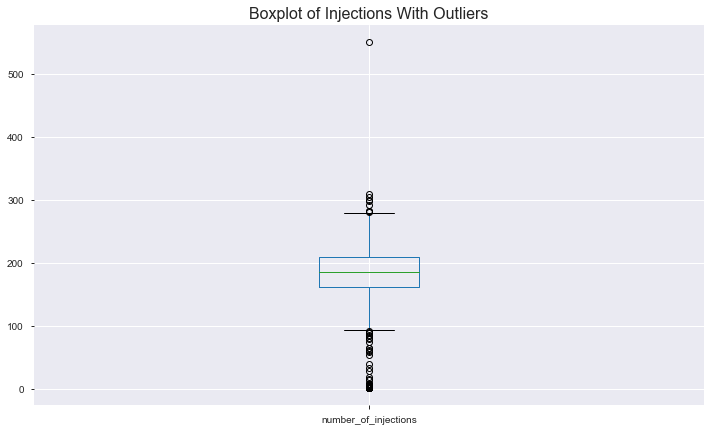

In [120]:
#searching for outliers using boxplot
new_df['number_of_injections'].plot(kind = 'box', figsize = (12, 7))
plt.title('Boxplot of Injections With Outliers', fontsize = 16);

In [121]:
#using the lower and upper quantiles to find outliers
q1 = pd.DataFrame(new_df).quantile(0.25)[0]
q3 = pd.DataFrame(new_df).quantile(0.75)[0]
iqr = q3 - q1 #Interquartile range

fence_low = q1 - (1.5*iqr)
fence_high = q3 + (1.5*iqr)

print(f'Lower Quantile Outliers are Below: {fence_low} Injections Per Day')
print(f'Upper Quantile Outliers are Above: {fence_high} Injections Per Day')

Lower Quantile Outliers are Below: 91.5 Injections Per Day
Upper Quantile Outliers are Above: 279.5 Injections Per Day


In [122]:
#I am going to remove all outliers included outside of lower and upper fences
outliers = []
outliers.append(new_df[new_df['number_of_injections'] > 281.5]['number_of_injections'])
outliers.append(new_df[new_df['number_of_injections'] < 117.5]['number_of_injections'])
outliers = pd.concat(outliers)
outliers = [outlier for outlier in outliers]

In [123]:
#drop outliers from data
for x in new_df['number_of_injections']:
    if x in outliers:
        new_df = new_df[new_df['number_of_injections'] != x]

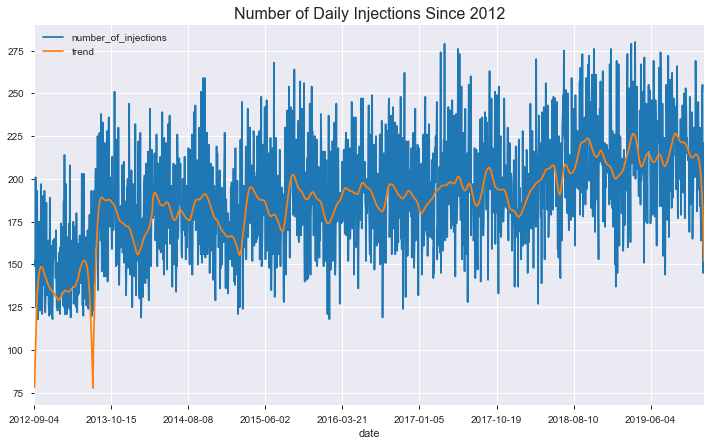

In [125]:
new_df.plot(figsize = (12, 7))
plt.title('Number of Daily Injections Since 2012', fontsize = 16);

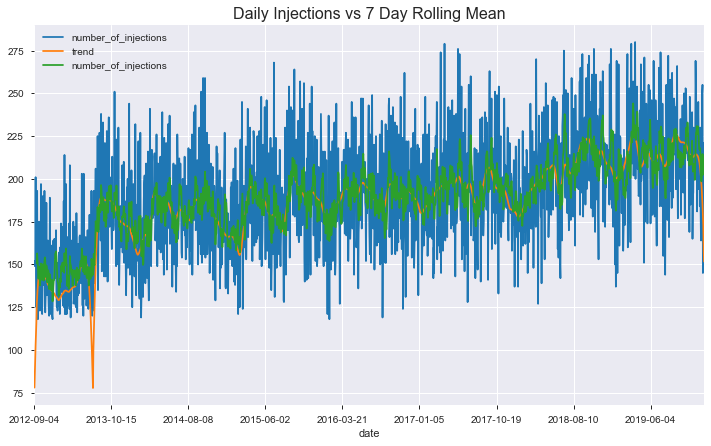

In [126]:
#now plot data against a rolling mean with a window size of 
new_df.plot(legend = True, figsize = (12, 7))
plt.title('Daily Injections vs 7 Day Rolling Mean', fontsize = 16)

#we can make the window ANY size
new_df.rolling(window = 7).mean()['number_of_injections'].plot(legend = True);

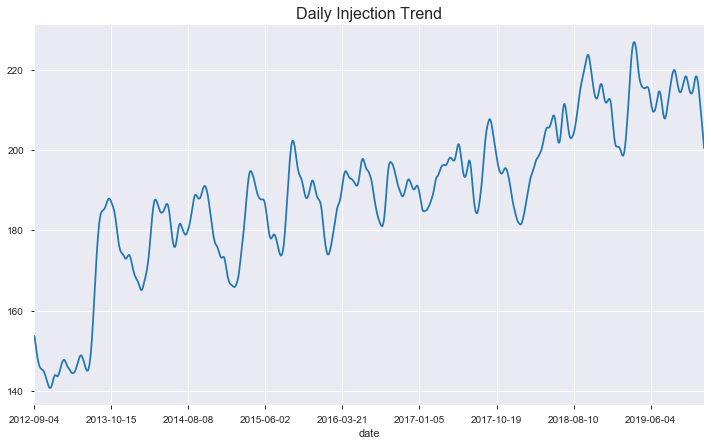

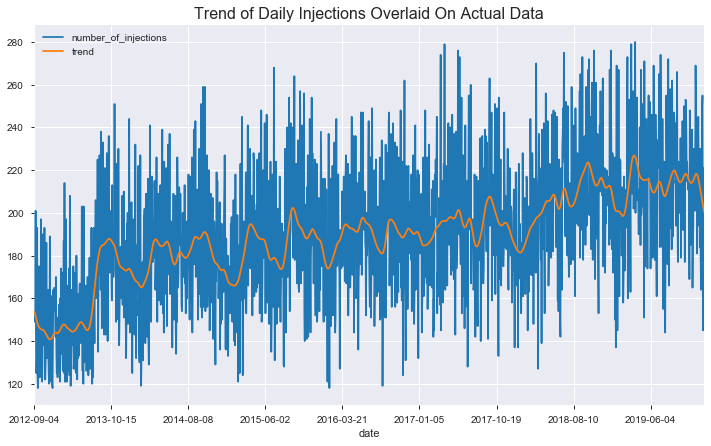

In [127]:
#use statsmodels to get the trend (hodrick-prescott filter)
# tuple unpacking gdp_cycle, gdp_trend
cycle, trend = hpfilter(new_df.number_of_injections, lamb = 1600)

trend.plot(figsize = (12, 7))
plt.title('Daily Injection Trend', fontsize = 16)

#add trend column to d1_2019 so that we can plot the trend on top of the df
new_df['trend'] = trend

#plot the trend over the data
new_df[['number_of_injections', 'trend']].plot(figsize = (12, 7))
plt.title('Trend of Daily Injections Overlaid On Actual Data', fontsize = 16);

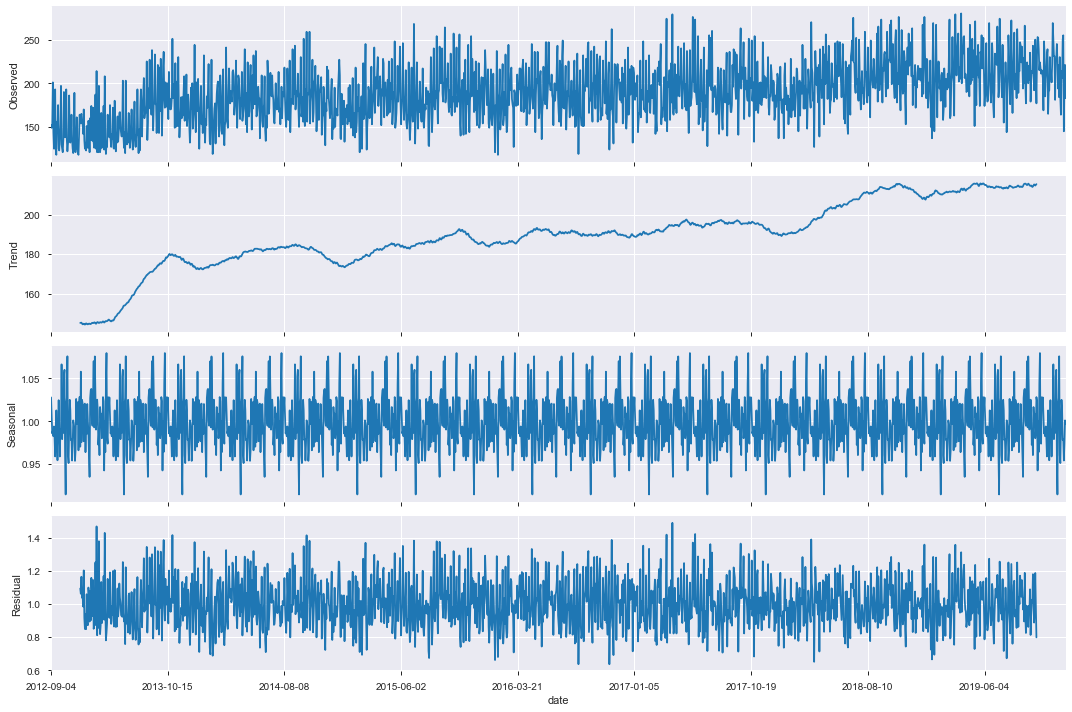

In [129]:
#this is basically separating our data into three different facets, error/seasonality/trend, so we can call those three things as if they are methods of the 
# multiplicative model
new_results = seasonal_decompose(new_df['number_of_injections'], model = 'mult', freq = 100)

#make plot larger
from pylab import rcParams

rcParams['figure.figsize'] = 15, 10 #specify figsize

new_results.plot(); #we have to put the ; after the plot for some reason, its weird without it

## So This New df Is Not Stationary
- This can be dealth with by using differencing if I move on to SARIMA modeling

In [131]:
#is the data stationary?
adf_test(new_df['number_of_injections'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.69
p-value                   0.08
# lags used              23.00
# observations         1716.00
critical value (1%)      -3.43
critical value (5%)      -2.86
critical value (10%)     -2.57
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


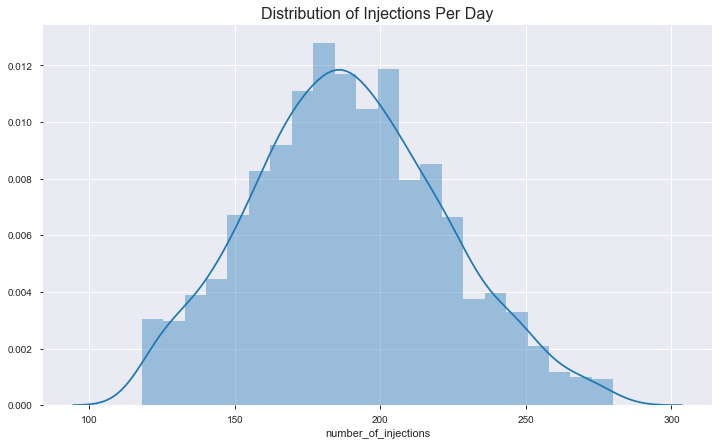

In [132]:
#check to see if the distribution of the residuals is normal, this would be ideal for modeling, it seems as though the data is close to normally distributed
plt.figure(figsize = (12, 7))
sns.distplot(new_df['number_of_injections'])
plt.title('Distribution of Injections Per Day', fontsize = 16);

In [133]:
#checking skew and kurtosis, looks like the data is skewed, which will probably throw off a normality test
new_df['number_of_injections'].skew()
new_df['number_of_injections'].kurtosis()

0.18539484551748714

-0.32771048276360526

In [134]:
#we can also run a shapiro-wilk test for normality testing, this shows us that we are dealing with non-normal data, but I am not overly concerned with this right
# now since the data is not too different from normal in the visual, I will keep this in mind moving forward though and potentially try to transform the data
stats.normaltest(new_df['number_of_injections'])

NormaltestResult(statistic=20.83700450922336, pvalue=2.9874590509196427e-05)

___
## Triple Exponential Smoothing



In [135]:
new_df.shape

(1740, 2)

In [137]:
# I want to forecast one business week in advance, which means 5 days, I have to transform the data into a 'double' dtype as well for Exponential Smoothing
new_train = new_df['number_of_injections'][:1735].astype('double')
new_test = new_df['number_of_injections'][1735:].astype('double')

__Fitting the model with several different seasonality values, finding which one produces the lowest RMSE for a week of predictions__

In [139]:
#brute force search for lowest RMSE by iterating through every possible seasonal_period in the data
seasonality_list = list(range(2, 1735, 1))
errors = []
for days in seasonality_list:
    try:
        errors.append(np.sqrt(mean_squared_error(new_test, ExponentialSmoothing(new_train, trend = 'mul', seasonal = 'mul', seasonal_periods = days).fit().forecast(5))))
    except: #some of the seasonal_periods produce nan values due to the inability for the model to account for that periodicity, so I have to bypass those 
        errors.append(0) #append 0 to the list of errors if an exception occurs

In [140]:
#looking for lowest RMSE for seasonal_periods, looks like our RMSEs got significantly better with the addition of the new data
for idx, x in enumerate(errors):
    if x < 16 and x != 0:
        print(idx, x)

1023 9.5821612034037
1520 15.619900170747611


In [142]:
# looks like 1025 is the best number here (index + 2)
new_fitted_model = ExponentialSmoothing(train, trend='mul',seasonal='mul',seasonal_periods=1025).fit()

In [143]:
#forecast
new_test_predictions = new_fitted_model.forecast(5).rename('HW Forecast')

#set the index of the test predictions to datetime of test set
new_test_predictions = pd.DataFrame(new_test_predictions).set_index(new_test.index)

In [144]:
new_test

date
2019-12-23   255.00
2019-12-26   145.00
2019-12-27   202.00
2019-12-31   221.00
2020-01-02   183.00
Name: number_of_injections, dtype: float64

In [145]:
new_test_predictions

,HW Forecast
date,
2019-12-23,254.53
2019-12-26,159.20
2019-12-27,199.55
2019-12-31,214.10
2020-01-02,197.26


In [146]:
#evaluate Model
print(f'RMSE of Triple Exponential Smoothing: {np.sqrt(mean_squared_error(new_test,new_test_predictions))} Injections Per Day')

RMSE of Triple Exponential Smoothing: 9.5821612034037 Injections Per Day


## Predict Future Data 

In [147]:
# Make predictions
new_fcast = new_fitted_model.predict(start=len(new_df), end=len(new_df)+4).rename('Forecast')

In [148]:
new_fcast

1740   273.44
1741   188.26
1742   161.35
1743   200.54
1744   213.96
Name: Forecast, dtype: float64